<h1 align="center">EQE512 MATRIX METHODS IN STRUCTURAL ANALYSIS 
<br>
<br>
Week 13
<br>
<br>
Nonlinear Static Procedure- OpenSeesPy
</h1> 

<h3 align="center">Dr. Ahmet Anıl Dindar (adindar@gtu.edu.tr)</h3> 
<h4 align="center">2021 Fall  </h4> 

---
**Today's Topics**

Material nonlinearity & nonlinear static procedure (NSP) for SDOF (Cantilever column). We'll write a NSP code from the scratch. 



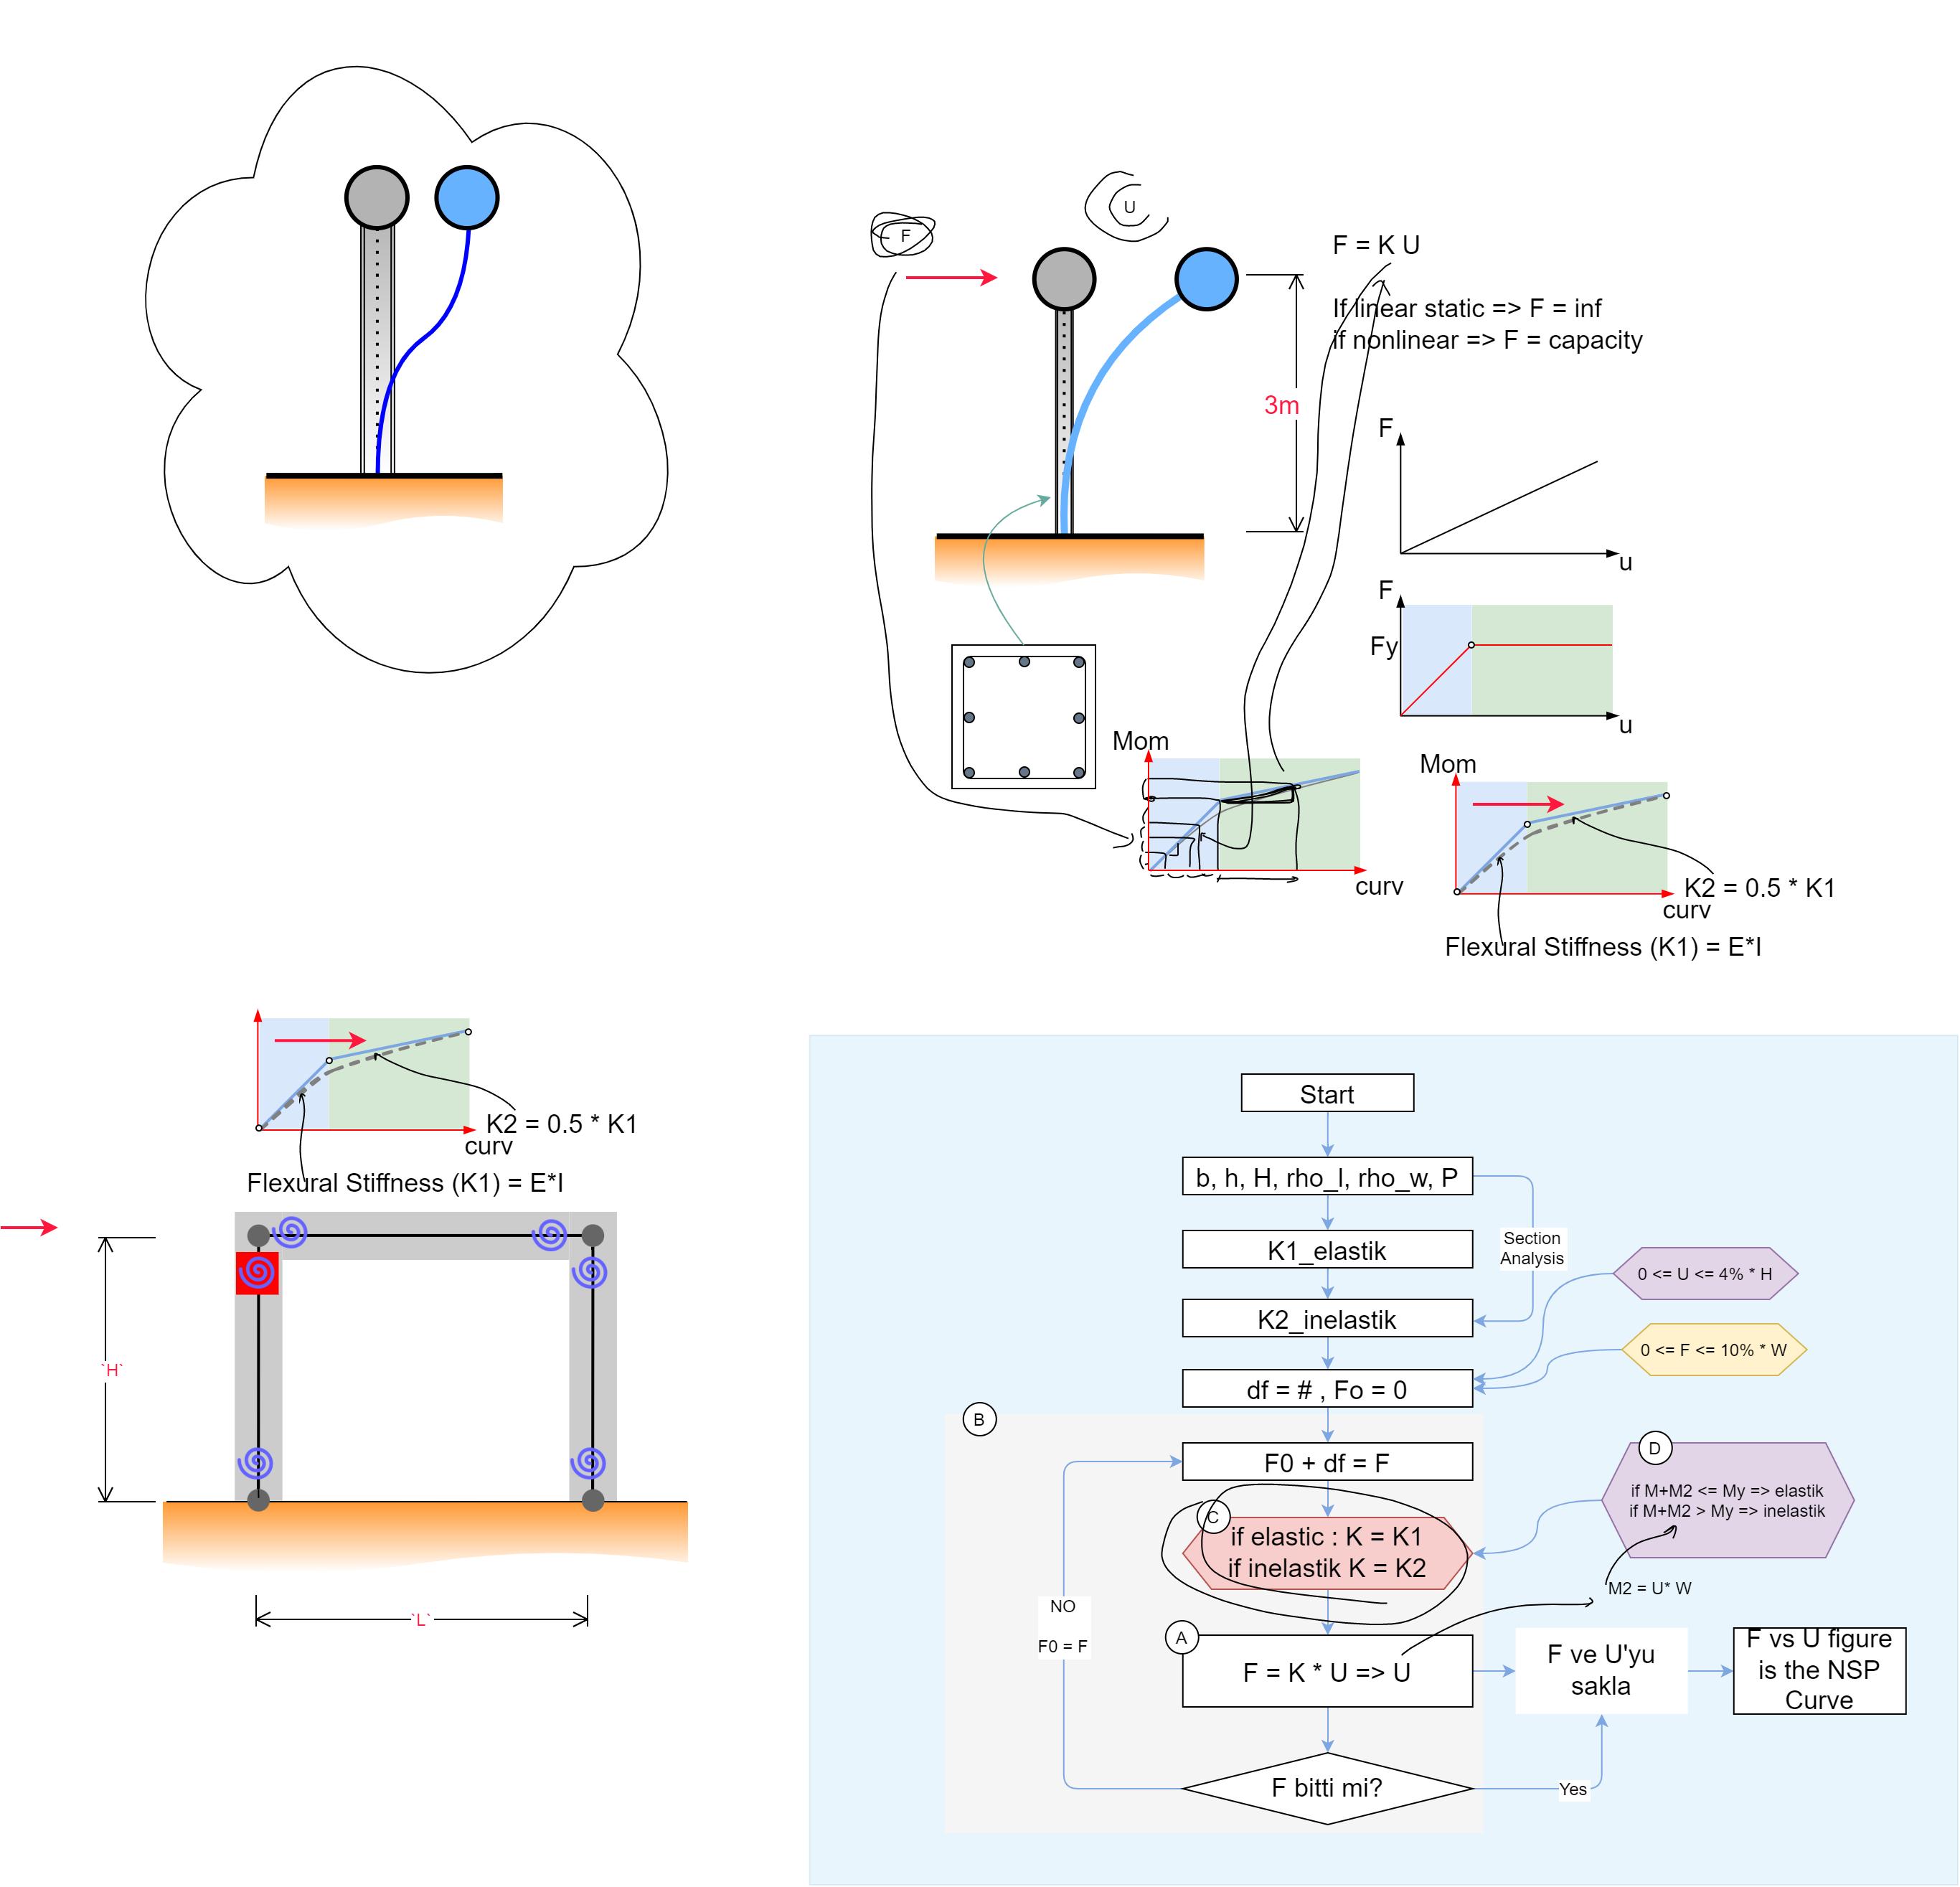

---
## Let's give an example on SDOF system

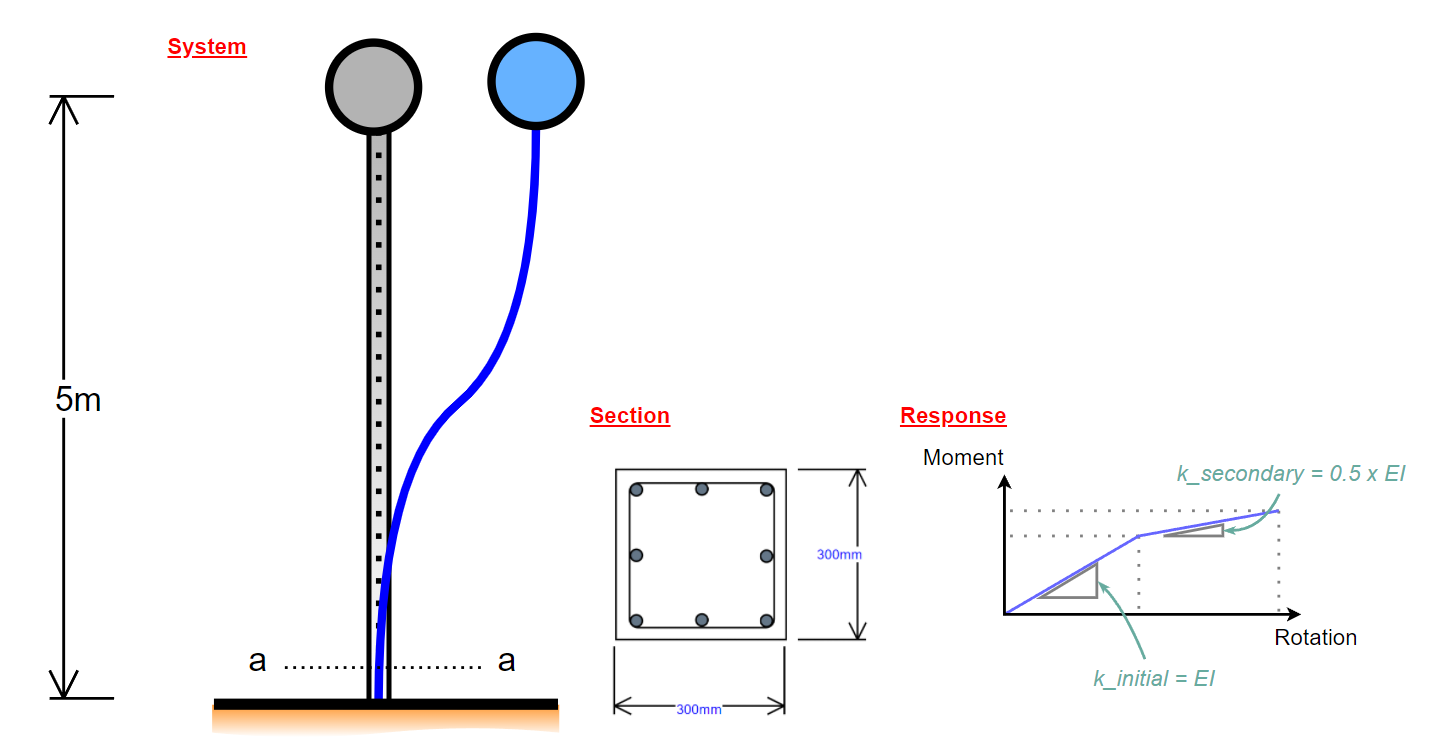


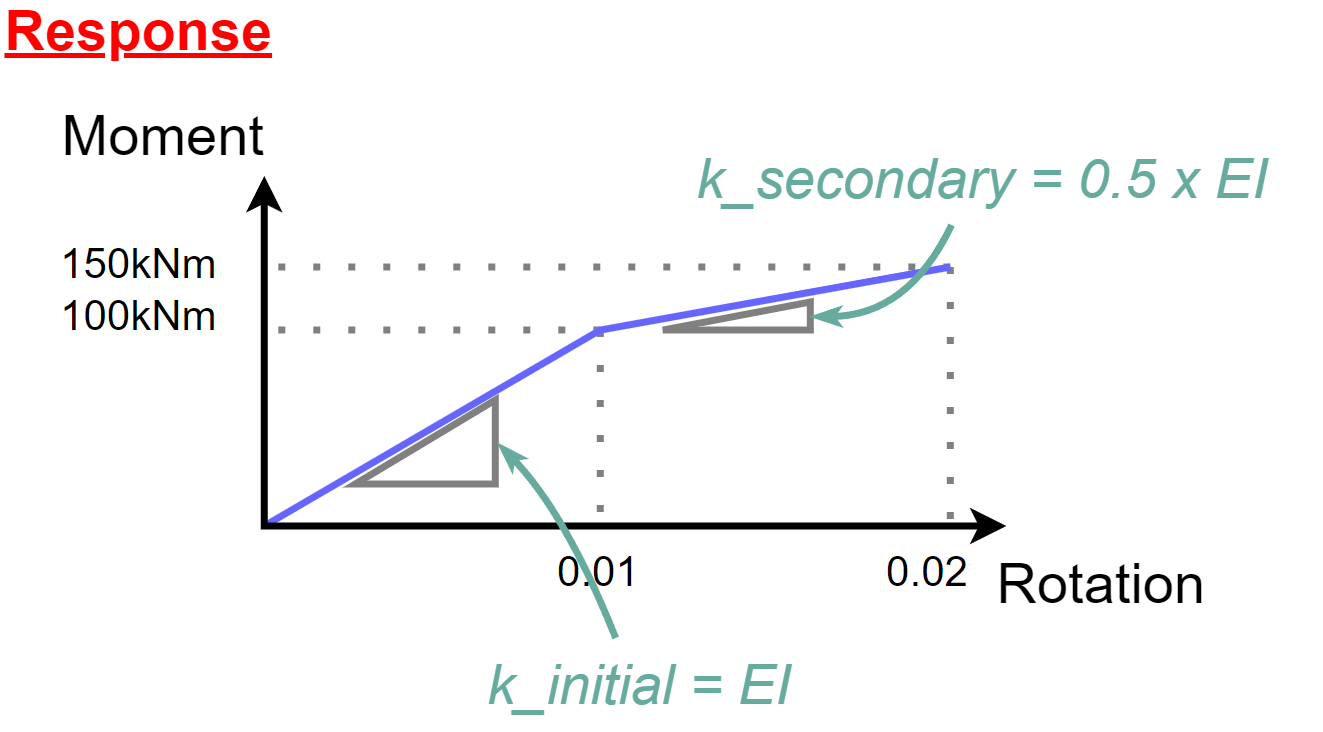

### Primitive approach:

Tekil kolon => Kayma Çerçevesi => K_yanal = $ n \times \frac{E\times I}{H^3}$

```
def stiffness_nonlin( M , M_cap , K_yanal , secondary_coeff = 0.5):
    if M <= M_cap : 
        k = K_yanal
    elif M > M_cap : 
        k = 0.5 x K_yanal        
    return k
    
force_list  , u_list = [] , []    
for delta_force in range( 0 , 101):
    force = delta_force
    M = force * H
    M_cap = xxxx
    K_yanal = 12 * E * I / H^3
    secondary_coeff = 0.5
    
    k = stiffness_nonlin( M , M_cap , K_yanal , secondary_coeff ) 
    
    # Remember the force-deformation 
    # k * U = force
    U = force / k
    
    # Storing 
    force_list.append( force) 
    u_list.appebd( U ) 
    
plt.plot( U_list , force_list)     

```

### Using the stiffness of entire freedoms

Equilibrium equation and force-deformaiton is applicable. 

Thus, obtain the member = system stiffness matrix which is not constant along with the change of either force of displacement. 

In [92]:
#----------------------------------------------------------------------------
# Linear response 
def column_stiffness_matrix( E , A , I , x1,y1,x2,y2):
    delta_1 = (x2-x1)
    delta_2 = (y2-y1)
    L = ( (delta_1)**2 + (delta_2)**2)**(0.5)
    #
    EA_L = E * A / L
    EI_L = E * I / L
    EI_L2 = EI_L / L
    EI_L3 = EI_L2 / L
    #
    k = np.array([[EA_L , 0 , 0 , -EA_L , 0 , 0],
                  [ 0 , 12*EI_L3 , 6*EI_L2 ,0 , -12*EI_L3 , 6*EI_L2 ],
                  [ 0 , 6*EI_L2 , 4*EI_L , 0 , -6*EI_L2 , 2*EI_L ],
                  [ -EA_L , 0 , 0 , EA_L , 0 , 0 ],
                  [ 0 , -12*EI_L3 ,-6*EI_L2 , 0 , 12*EI_L3 , -6*EI_L2 ],
                  [ 0 , 6*EI_L2 , 2*EI_L , 0 , -6*EI_L2 , 4*EI_L]])
                  
    return( k )

#----------------------------------------------------------------------------
# Nonlinear response 
def column_stiffness_matrix_nonlinear( E , A , I , x1,y1,x2,y2 , P_cap=[0,0,0,0,0,0]  , P_act =[0,0,0,0,0,0]   , k_sec= [1 ,1,1,1,1,1,] ):
    print( f"column_stiffness_matrix_nonlinear P_cap = {P_cap}")
    print( f"column_stiffness_matrix_nonlinear P_act = {P_act}")
    print( f"column_stiffness_matrix_nonlinear k_sec = {k_sec}")

    delta_1 = (x2-x1)
    delta_2 = (y2-y1)
    L = ( (delta_1)**2 + (delta_2)**2)**(0.5)
    #
    EA_L = E * A / L
    EI_L = E * I / L
    EI_L2 = EI_L / L
    
    if P_act[2] <= P_cap[2] :
        EI_L3 = EI_L2 / L
    elif P_act[2] > P_cap[2] : 
        EI_L3 = k_sec[1] * EI_L2 / L     
    #
    k = np.array([[EA_L , 0 , 0 , -EA_L , 0 , 0],
                  [ 0 , 12*EI_L3 , 6*EI_L2 ,0 , -12*EI_L3 , 6*EI_L2 ],
                  [ 0 , 6*EI_L2 , 4*EI_L , 0 , -6*EI_L2 , 2*EI_L ],
                  [ -EA_L , 0 , 0 , EA_L , 0 , 0 ],
                  [ 0 , -12*EI_L3 ,-6*EI_L2 , 0 , 12*EI_L3 , -6*EI_L2 ],
                  [ 0 , 6*EI_L2 , 2*EI_L , 0 , -6*EI_L2 , 4*EI_L]])
    
    print( f"column_stiffness_matrix_nonlinear k = \n{k}")
                  
    return( k )
#----------------------------------------------------------------------------
# Transformation matrix
    
import numpy as np

def transformation_matrix( x1,y1,x2,y2) :
    delta_1 = (x2-x1)
    delta_2 = (y2-y1)
    L = ( (delta_1)**2 + (delta_2)**2)**(0.5)
    
    T = np.array( [[ delta_1 / L , delta_2 / L  , 0 , 0 , 0 , 0],
                   [-delta_2 / L , delta_1 / L  , 0 , 0 , 0 , 0],
                   [0 , 0 , 1 , 0 , 0 , 0  ], 
                   [ 0 , 0 , 0 , delta_1 / L , delta_2 / L , 0 ],
                   [ 0 , 0 , 0, -delta_2 / L , delta_1 / L  , 0],
                   [0 , 0 , 0 , 0 , 0 , 1] ])
    
    return( T)

#----------------------------------------------------------------------------
# Frame global striffness matrix

def column_nonlinear_stiffness_matrix_global( member_props , show_T_K = False  ,  P_cap=[0,0,0,0,0,0]  , P_act =[0,0,0,0,0,0]   , k_sec= [1 ,1,1,1,1,1,]) :
    print( f"column_nonlinear_stiffness_matrix_global P_cap = {P_cap}")
    print( f"column_nonlinear_stiffness_matrix_global P_act = {P_act}")
    print( f"column_nonlinear_stiffness_matrix_global k_sec = {k_sec}")
    
    
    x1 , x2 = member_props["jointI"][0] , member_props["jointJ"][0] 
    y1 , y2  = member_props["jointI"][1] , member_props["jointJ"][1] 
    
    E = member_props["E"]
    A = member_props["A"]
    I = member_props["I"]
    
    #k = column_stiffness_matrix (  E , A , I , x1,y1,x2,y2 ) 
    k = column_stiffness_matrix_nonlinear(  E , A , I , x1,y1,x2,y2 , P_cap , P_act , k_sec ) 
    
    T = transformation_matrix( x1,y1,x2,y2  ) 
    
    if show_T_K == True : print( f"Transformation matrix = \n{T}\nand member stiffnes matrix = \n{k}" ) 
                                
    k_global =  np.matmul( np.matmul(np.transpose( T) , k ) , T )
                          
    return( k_global )

In [85]:
member_props = {"E": 20_000 , "A": 300*300  , "I": (300**4)/12 , "jointI": [0,0] , "jointJ":[0,5_000]}

In [93]:
k1 = column_nonlinear_stiffness_matrix_global( member_props )

column_nonlinear_stiffness_matrix_global P_cap = [0, 0, 0, 0, 0, 0]
column_nonlinear_stiffness_matrix_global P_act = [0, 0, 0, 0, 0, 0]
column_nonlinear_stiffness_matrix_global k_sec = [1, 1, 1, 1, 1, 1]
column_stiffness_matrix_nonlinear P_cap = [0, 0, 0, 0, 0, 0]
column_stiffness_matrix_nonlinear P_act = [0, 0, 0, 0, 0, 0]
column_stiffness_matrix_nonlinear k_sec = [1, 1, 1, 1, 1, 1]
column_stiffness_matrix_nonlinear k = 
[[ 3.600e+05  0.000e+00  0.000e+00 -3.600e+05  0.000e+00  0.000e+00]
 [ 0.000e+00  1.296e+03  3.240e+06  0.000e+00 -1.296e+03  3.240e+06]
 [ 0.000e+00  3.240e+06  1.080e+10  0.000e+00 -3.240e+06  5.400e+09]
 [-3.600e+05  0.000e+00  0.000e+00  3.600e+05  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.296e+03 -3.240e+06  0.000e+00  1.296e+03 -3.240e+06]
 [ 0.000e+00  3.240e+06  5.400e+09  0.000e+00 -3.240e+06  1.080e+10]]


In [87]:
k1

array([[ 1.296e+03,  0.000e+00, -3.240e+06, -1.296e+03,  0.000e+00,
        -3.240e+06],
       [ 0.000e+00,  3.600e+05,  0.000e+00,  0.000e+00, -3.600e+05,
         0.000e+00],
       [-3.240e+06,  0.000e+00,  1.080e+10,  3.240e+06,  0.000e+00,
         5.400e+09],
       [-1.296e+03,  0.000e+00,  3.240e+06,  1.296e+03,  0.000e+00,
         3.240e+06],
       [ 0.000e+00, -3.600e+05,  0.000e+00,  0.000e+00,  3.600e+05,
         0.000e+00],
       [-3.240e+06,  0.000e+00,  5.400e+09,  3.240e+06,  0.000e+00,
         1.080e+10]])

In [94]:
k2 = column_nonlinear_stiffness_matrix_global( member_props ,P_act =[0,0,1,0,0,0] , k_sec = [ 1 , .5 , 1 , 1 ,.5 ,1])

column_nonlinear_stiffness_matrix_global P_cap = [0, 0, 0, 0, 0, 0]
column_nonlinear_stiffness_matrix_global P_act = [0, 0, 1, 0, 0, 0]
column_nonlinear_stiffness_matrix_global k_sec = [1, 0.5, 1, 1, 0.5, 1]
column_stiffness_matrix_nonlinear P_cap = [0, 0, 0, 0, 0, 0]
column_stiffness_matrix_nonlinear P_act = [0, 0, 1, 0, 0, 0]
column_stiffness_matrix_nonlinear k_sec = [1, 0.5, 1, 1, 0.5, 1]
column_stiffness_matrix_nonlinear k = 
[[ 3.60e+05  0.00e+00  0.00e+00 -3.60e+05  0.00e+00  0.00e+00]
 [ 0.00e+00  6.48e+02  3.24e+06  0.00e+00 -6.48e+02  3.24e+06]
 [ 0.00e+00  3.24e+06  1.08e+10  0.00e+00 -3.24e+06  5.40e+09]
 [-3.60e+05  0.00e+00  0.00e+00  3.60e+05  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.48e+02 -3.24e+06  0.00e+00  6.48e+02 -3.24e+06]
 [ 0.00e+00  3.24e+06  5.40e+09  0.00e+00 -3.24e+06  1.08e+10]]


In [89]:
k2

array([[ 6.48e+02,  0.00e+00, -3.24e+06, -6.48e+02,  0.00e+00, -3.24e+06],
       [ 0.00e+00,  3.60e+05,  0.00e+00,  0.00e+00, -3.60e+05,  0.00e+00],
       [-3.24e+06,  0.00e+00,  1.08e+10,  3.24e+06,  0.00e+00,  5.40e+09],
       [-6.48e+02,  0.00e+00,  3.24e+06,  6.48e+02,  0.00e+00,  3.24e+06],
       [ 0.00e+00, -3.60e+05,  0.00e+00,  0.00e+00,  3.60e+05,  0.00e+00],
       [-3.24e+06,  0.00e+00,  5.40e+09,  3.24e+06,  0.00e+00,  1.08e+10]])

column_nonlinear_stiffness_matrix_global P_cap = [0, 0, 0, 0, 0, 0]
column_nonlinear_stiffness_matrix_global P_act = [1, 1, 1, 1, 1, 1]
column_nonlinear_stiffness_matrix_global k_sec = [1, 1, 1, 1, 1, 1]
column_stiffness_matrix_nonlinear P_cap = [0, 0, 0, 0, 0, 0]
column_stiffness_matrix_nonlinear P_act = [1, 1, 1, 1, 1, 1]
column_stiffness_matrix_nonlinear k_sec = [1, 1, 1, 1, 1, 1]
column_stiffness_matrix_nonlinear k = 
[[ 3.600e+05  0.000e+00  0.000e+00 -3.600e+05  0.000e+00  0.000e+00]
 [ 0.000e+00  1.296e+03  3.240e+06  0.000e+00 -1.296e+03  3.240e+06]
 [ 0.000e+00  3.240e+06  1.080e+10  0.000e+00 -3.240e+06  5.400e+09]
 [-3.600e+05  0.000e+00  0.000e+00  3.600e+05  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.296e+03 -3.240e+06  0.000e+00  1.296e+03 -3.240e+06]
 [ 0.000e+00  3.240e+06  5.400e+09  0.000e+00 -3.240e+06  1.080e+10]]
column_nonlinear_stiffness_matrix_global P_cap = [0, 1, 0, 0, 0, 0]
column_nonlinear_stiffness_matrix_global P_act = [1, 1, 1, 1, 1, 1]
column_nonlinear_stiffn

ValueError: x and y can be no greater than 2-D, but have shapes (100, 6, 6) and (100,)

C:\Users\user\AppData\Local\Temp/ipykernel_13800/1212579727.py:13: RuntimeWarning: divide by zero encountered in true_divide
  u = P / k


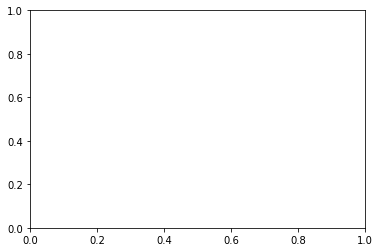

In [97]:
force_list , disp_list = [] , []

for force in range(0 , 100) :
    # Give the values for 
    k_sec=[1, 1, 1, 1, 1, 1]
    
    P_cap=[0, 0, 1 , 0, 0, 1 ]
    
    P_act=[0, force , 0, 0, 0, 0]
    
    k = column_nonlinear_stiffness_matrix_global(member_props , P_cap , P_act , k_sec)
    
    u = P / k
    
    # Append
    
    force_list.append( force)
    disp_list.append( u )
    
# Finally
plt.plot( disp_list , force_list )
    

---

## What about in OpenSeesPy

Obtainin the capacity curve of a SDOF cantilever column using OpenSeesPY


---

Gravity ok


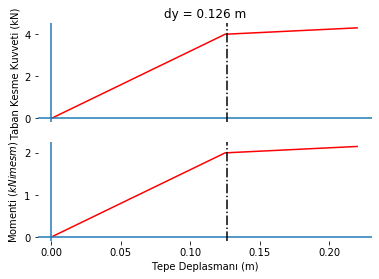

In [133]:
######################################################
#
# 2021_0526-AAD: Tekil kolonda beamWithHinges
#
######################################################
"""
Tek serbestlik dereceli bir sistemin çözümlenmesi

"""

#%% IMPORT MODULE ######################################################
import openseespy.opensees as osp
import matplotlib.pyplot as plt
import math
import datetime 

#%% MODELLING  ######################################################
# Create ModelBuilder (with two-dimensions and 3 DOF/node)
osp.wipe()

osp.model('basic', '-ndm', 2, '-ndf', 3)

# Set parameters for overall model geometry
height = 500

# Create nodes
#    tag, X, Y
osp.node(1, 0.0, 0.0)
osp.node(2, 0.0, height)

# Fix supports at base of columns
#   tag, DX, DY, RZ
osp.fix(1, 1, 1, 1)

#Define Elements and Sections
ColMatTagFlex  = 2
ColMatTagAxial = 3
ColSecTag = 1
BeamSecTag = 2

# Properties
fc = -20.0 # 
Ec = 28_000 # 
IzCol = (500)**4/12
ACol = 500**2

#Column Section
EICol = Ec*IzCol # EI, for moment-curvature relationship
EACol = Ec*ACol # EA, for axial-force-strain relationship
MyCol = 2_000 # yield Moment calculated
PhiYCol = 1.0e-3	# yield curvature
EIColCrack = MyCol/PhiYCol	# cracked section inertia
b = .1 # strain-hardening ratio (ratio between post-yield tangent and initial elastic tangent)

# Kesit Tanımlanıyor #############################
# steel moment curvature is used for Mz of the section only, # bilinear behavior for flexure
osp.uniaxialMaterial('Steel01', ColMatTagFlex, MyCol, EIColCrack, b) 

# this is not used as a material, this is an axial-force-strain response
osp.uniaxialMaterial('Elastic', ColMatTagAxial, EACol) 

# combine axial and flexural behavior into one section (no P-M interaction here)
osp.section('Aggregator', ColSecTag, ColMatTagAxial, 'P', ColMatTagFlex, 'Mz')  

# Eleman Tanımlanıyor #############################
ColTransfTag = 1
osp.geomTransf('Linear', ColTransfTag)
eleTag = 1
# Number of integration points along length of element
np = 2

# Lobatto integratoin
osp.beamIntegration('Lobatto', 1, 1, np)

# Create the coulumns using Beam-column elements
#               e            tag ndI ndJ transfTag integrationTag
eleType = 'forceBeamColumn'
osp.element(eleType, 1, 1, 2, 1, 1)

#%% DÜŞEY YÜKLEME TANIMLANMASI ######################################################

#  a parameter for the axial load
P = 1000.0;  # 10% of axial capacity of columns

# Create a Plain load pattern with a Linear TimeSeries
osp.timeSeries('Linear', 1)
osp.pattern('Plain', 1, 1)

# Create nodal loads at nodes 3 & 4
#    nd  FX,  FY, MZ
osp.load(2, 0.0, -P, 0.0)

#%% DÜŞEY YÜKLEME ANALİZİ ######################################################

# Create the system of equation, a sparse solver with partial pivoting
osp.system('BandGeneral')
# Create the constraint handler, the transformation method
osp.constraints('Transformation')
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
osp.numberer('RCM')
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
osp.test('NormDispIncr', 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
osp.algorithm('Newton')
# Create the integration scheme, the LoadControl scheme using steps of 0.1
osp.integrator('LoadControl', 0.1)
# Create the analysis object
osp.analysis('Static')
# perform the gravity load analysis, requires 10 steps to reach the load level
gravitySonuc = osp.analyze(10)
if gravitySonuc == 0: 
    print( "Gravity ok")

#%% PUSH-OVER ANALYSIS ######################################################

# Set some parameters
H = 1.0  # Reference lateral load

# Set lateral load pattern with a Linear TimeSeries
osp.pattern('Plain', 2, 1)

# Create nodal loads at nodes 3 & 4
#    nd    FX  FY  MZ
osp.load( 2, H, 0.0, 0.0)

# Set some parameters
dU = 1 # Displacement increment

# Change the integration scheme to be displacement control
#                             node dof init Jd min max
osp.integrator('DisplacementControl', 2, 1, dU, 1, dU, dU)

# RECORDER #######################
# Stop the old recorders by destroying them
# remove recorders

# Create a recorder to monitor nodal displacements
# recorder Node -file node32.out -time -node 3 4 -dof 1 2 3 disp

# Create a recorder to monitor element forces in columns
# recorder EnvelopeElement -file ele32.out -time -ele 1 2 forces

# Set some parameters
maxU = 220  # Max displacement
currentDisp = 0.0
ok = 0

osp.test('NormDispIncr', 1.0e-12, 1000)
osp.algorithm('ModifiedNewton', '-initial')

disp , baseshear , axialForce =  [],[] , []

while ok == 0 and currentDisp < maxU:

    ok = osp.analyze(1)

    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("modified newton failed")
        break
    # print "regular newton failed .. lets try an initail stiffness for this step"
    # test('NormDispIncr', 1.0e-12,  1000)
    # # algorithm('ModifiedNewton', '-initial')
    # ok = analyze(1)
    # if ok == 0:
    #     print "that worked .. back to regular newton"

    # test('NormDispIncr', 1.0e-12,  10)
    # algorithm('Newton')

    currentDisp = osp.nodeDisp(2, 1)
    disp.append( currentDisp / 1_000 )
		
    osp.reactions()

    currentBaseShear = osp.nodeReaction(1 , 2 )
    currentaxialForce = osp.nodeReaction(1 , 3 )
    baseshear.append( currentBaseShear / 1_000 )
    axialForce.append( currentaxialForce / 1_000 )
    #print( round(currentDisp,2) , round( currentBaseShear,2) ) 

#
dy = [ itemDisp for itemForce , itemDisp in zip( baseshear , disp) if itemForce > MyCol / height][0]

#%% Görselleştirme 
# ######################################################

plt.figure()
plt.subplot(211)
plt.plot( disp , baseshear , c = "r" ) 
plt.title( f"dy = {dy} m")
plt.box(False)
plt.axhline(0)
plt.axvline(0)
plt.axvline( dy , ls = "-.", c = "k")
plt.ylabel("Taban Kesme Kuvveti (kN)")
plt.xticks([])

plt.subplot(212)

plt.plot( disp , axialForce , c = "r" ) 
plt.box(False)
plt.axhline(0)
plt.axvline(0)
plt.axvline( dy , ls = "-.", c = "k")
plt.xlabel("Tepe Deplasmanı (m)")
plt.ylabel( u"Momenti ($kN \times m$)")

plt.show()

# %%

